### This notebook opens a Sentinel-1 EW GRDM image and calibrates it, in the following 4 steps:
#### 1) open a Sentinel-1 EW GRDM data product from CVL with the xarray package (lazy loading)
#### 2) visualize the uncalibrated image data (amplitude values) using Cartopy
#### 2) calibrate both image channels (HH and HV polarization) using the Look-Up Table for Sigma Nought
#### 3) visualize the calbrated image using Cartopy

In [9]:
# imports
import os
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

### Step 1: open the Sentinel-1 EW GRDM data product selected in CVL using the xarray package

In [10]:
# open S1 image with xarray
#s1 = xr.open_dataset('https://nbstds.met.no/thredds/dodsC/NBS/S1A/2023/01/19/EW/S1A_EW_GRDM_1SDH_20230119T080256_20230119T080356_046850_059E12_D79F.nc')
s1 = xr.open_dataset('https://nbstds.met.no/thredds/dodsC/NBS/S1A/2020/03/30/EW/S1A_EW_GRDM_1SDH_20200330T043712_20200330T043819_031900_03AEB2_CC99.nc')

# show the netCDF file structure for this data product
s1

Note:Caching=1


<xarray.Dataset>
Dimensions:                      (time: 1, y: 10994, x: 10371, gcp_index: 483)
Coordinates:
  * time                         (time) datetime64[ns] 2020-03-30T04:37:12
    lat                          (y, x) float32 ...
    lon                          (y, x) float32 ...
Dimensions without coordinates: y, x, gcp_index
Data variables: (12/40)
    Amplitude_HH                 (time, y, x) float32 ...
    Amplitude_HV                 (time, y, x) float32 ...
    crsWGS84                     int32 ...
    dn_HH                        (time, y, x) float32 ...
    sigmaNought_HH               (time, y, x) float32 ...
    gamma_HH                     (time, y, x) float32 ...
    ...                           ...
    orbitList_HH                 int8 ...
    swathMergeList_HH            int8 ...
    coordinateConversionList_HH  int8 ...
    orbitList_HV                 int8 ...
    swathMergeList_HV            int8 ...
    coordinateConversionList_HV  int8 ...
Attributes: (12/26)
    title:                      Sentinel-1 GRD data
    netcdf4_version_id:         4.4.0
    file_creation_date:         2020-03-30T08:53:06Z
    PRODUCT_TYPE:               GRD
    ACQUISITION_STOP_TIME:      2020-03-30T04:38:19.005312
    ORBIT_NUMBER:               31900
    ...                         ...
    institution:                Norwegian Meteorological Institute
    ORBIT_DIRECTION:            DESCENDING
    LINE_SPACING:               4.000000e+01
    Conventions:                CF-1.6
    MISSION_ID:                 S1A
    history:                    2020-03-30T08:53:06Z. Converted from SAFE to ...

##### 'Data variables' contains the image data (e.g. 'Amplitude_HH'), as well as metadata (e.g. Ground Control Points and Look-Up Tables)
##### 'Attributes' contains more metadata, e.g. the sensor mode, available polarizations etc. 
##### Here, we show how to extract the image data and some metadata from the xarray dataset:

In [11]:
# accessing all values on the server is very slow, so use only every x-th value
stride = 25

# lat/lon
lon = s1['lon'][::stride,::stride]
lat = s1['lat'][::stride,::stride]

# extract the extent of the image in geodetic coordinates
lon_min_geo = np.min(lon)
lon_max_geo = np.max(lon)
lat_min_geo = np.min(lat)
lat_max_geo = np.max(lat)

print('The image ranges in longitude from: ', lon_min_geo , 'degrees to ', lon_max_geo, 'degrees.')
print('The image ranges in latitude from: ', lat_min_geo , 'degrees to ', lat_max_geo, 'degrees.')

Sentinel-1 scene name is: Sentinel-1 GRD data
The image ranges in longitude from:  <xarray.DataArray 'lon' ()>
array(28.71151161) degrees to  <xarray.DataArray 'lon' ()>
array(48.5362587) degrees.
The image ranges in latitude from:  <xarray.DataArray 'lat' ()>
array(73.38687897) degrees to  <xarray.DataArray 'lat' ()>
array(78.35325623) degrees.


### Step 2: plot the amplitude values ( = uncalibrated data) of both image channels (HH and HV)
#### Note: step 2-4 can be slow, because the Sentinel-1 EW GRDM image is a very large data product.

In [12]:
# grab the amplitude values for the HH and HV image channels
ampl_HH = s1["Amplitude_HH"][0,::stride,::stride]
ampl_HV = s1["Amplitude_HV"][0,::stride,::stride]

lon = s1['lon'][::stride,::stride]
lat = s1['lat'][::stride,::stride]

# find vmin, vmax, which are the 2nd and 98th percentile of each band. Those are used when plotting, to increases contrast in the image.
vmin_HH = np.nanpercentile(ampl_HH, 2)
vmax_HH = np.nanpercentile(ampl_HH, 98)
vmin_HV = np.nanpercentile(ampl_HV, 2)
vmax_HV = np.nanpercentile(ampl_HV, 98)

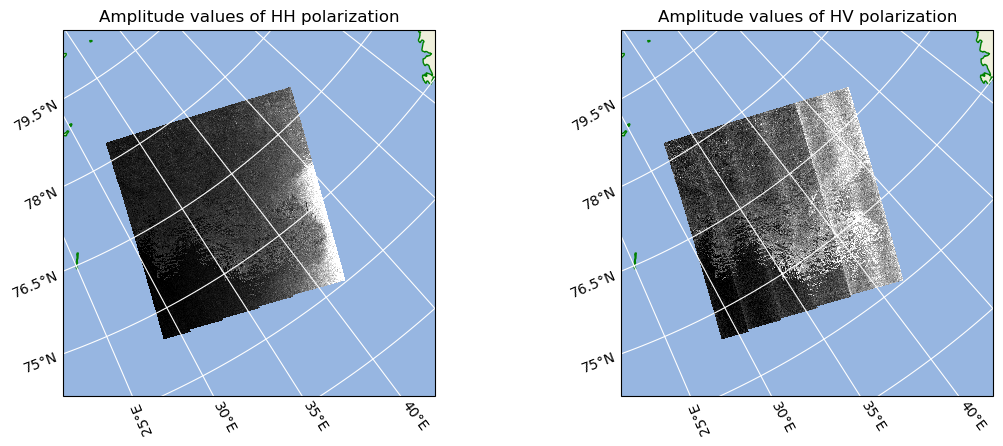

In [13]:
# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

fig, axes = plt.subplots(1,2, figsize=(12,5), subplot_kw={'projection': target_projection},sharex=True,sharey=True)
axes = axes.ravel()

axes[0].set_extent([lon_min_geo-1,lon_max_geo+1, lat_min_geo, lat_max_geo])
axes[0].add_feature(cartopy.feature.LAND)
axes[0].add_feature(cartopy.feature.OCEAN)
gl0 = axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
axes[0].coastlines(color='green')
axes[0].pcolormesh(lon, lat, ampl_HH, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
axes[0].set_title('Amplitude values of HH polarization')
gl0.top_labels = False
gl0.right_labels = False

axes[1].set_extent([lon_min_geo-1,lon_max_geo+1, lat_min_geo, lat_max_geo])
axes[1].add_feature(cartopy.feature.LAND)
axes[1].add_feature(cartopy.feature.OCEAN)
gl1 = axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
axes[1].coastlines(color='green')
axes[1].pcolormesh(lon, lat, ampl_HV, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)
axes[1].set_title('Amplitude values of HV polarization')
gl1.top_labels = False
gl1.right_labels = False

plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

### Step 3: Radiometric calibration of the image
In this step, we calibrate both image channels (HH and HV) using the Look-Up Table for Sigma Nought. After calibration, we convert the values to decibels (dB). 

**Note:** this step is very slow, because we need to access all values from both image bands on the server. Be patient:)

In [ ]:
# grab digital numbers
dn_HH = s1['Amplitude_HH']
dn_HV = s1['Amplitude_HV']

# grab Look-Up-Table (LUT) for sigma nought
lut_HH = s1['sigmaNought_HH']
lut_HV = s1['sigmaNought_HV']

# calculate sigma nought values
sigma_n_HH = dn_HH**2 / lut_HH**2
sigma_n_HV = dn_HV**2 / lut_HV**2

# convert to dB
sigma_n_HH_db = 10*np.log10(sigma_n_HH)
sigma_n_HV_db = 10*np.log10(sigma_n_HV)

Error:curl error: Failure when receiving data from the peer
Error:DAP DATADDS packet is apparently too short
Error:DAP DATADDS packet is apparently too short
Error:curl error: Stream error in the HTTP/2 framing layer
Error:DAP DATADDS packet is apparently too short


### Step 4: plot the calibrated bands

In [ ]:
# substep data when plotting
sigma_HH_db = sigma_n_HH_db[0,::stride,::stride]
sigma_HV_db = sigma_n_HV_db[0,::stride,::stride]

# vmin, vmax are the 2nd and 98th percentile in the image data, this increases contrast when plotting the S1 image
vmin_HH_db = np.nanpercentile(sigma_HH_db, 2)
vmax_HH_db = np.nanpercentile(sigma_HH_db, 98)
vmin_HV_db = np.nanpercentile(sigma_HV_db, 2)
vmax_HV_db = np.nanpercentile(sigma_HV_db, 98)

# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

# plot image
fig, axes = plt.subplots(1,2, figsize=(12,5), subplot_kw={'projection': target_projection},sharex=True,sharey=True)
axes = axes.ravel()

axes[0].set_extent([lon_min_geo-1,lon_max_geo+1, lat_min_geo, lat_max_geo])
axes[0].add_feature(cartopy.feature.LAND)
axes[0].add_feature(cartopy.feature.OCEAN)
gl0 = axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
axes[0].coastlines(color='green')
axes[0].pcolormesh(lon, lat, sigma_HH_db, transform=orig_projection, cmap='gray', vmin=vmin_HH_db, vmax=vmax_HH_db)
axes[0].set_title('$\sigma_0$ HH')
gl0.top_labels = False
gl0.right_labels = False

axes[1].set_extent([lon_min_geo-1,lon_max_geo+1, lat_min_geo, lat_max_geo])
axes[1].add_feature(cartopy.feature.LAND)
axes[1].add_feature(cartopy.feature.OCEAN)
gl1 = axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
axes[1].coastlines(color='green')
axes[1].pcolormesh(lon, lat, sigma_HV_db, transform=orig_projection, cmap='gray', vmin=vmin_HV_db, vmax=vmax_HV_db)
axes[1].set_title('$\sigma_0$ HV')
gl1.top_labels = False
gl1.right_labels = False

plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

TO DO: crop image data (x from 8400:8900 and y from 3600:4600 ) and paste cells from ice_water_classification here